# Functions to preprocess data
### Should require a pandas dataframe as input
### Should provide a pandas dataframe as output

In [167]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [195]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

df original shape:  (92834, 3)


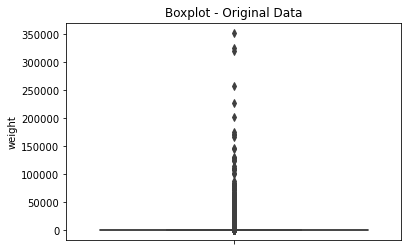

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (88078, 3)


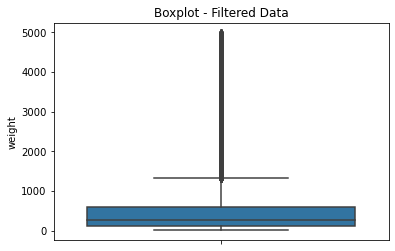

filtered data - stats:
count    88078.000000
mean       517.838836
std        699.040550
min         10.000000
25%        118.000000
50%        267.000000
75%        604.000000
max       4991.000000
Name: weight, dtype: float64


% of removed records: 0.0512


In [201]:
weights_filtered = remove_extreme_weights(weights_df,10,5000)

In [207]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [208]:
weights_for_model = remove_users_lowcount(weights_filtered,20)

df original shape:  (88078, 3)
unique users:  1869
users with less than 20 artists: 66
unique users after removal:  1803
df new shape:  (87441, 3)
% of removed records: 0.0072


In [204]:
def train_test_split(df,sample_size):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    sample_size must be smaller than total artist count per user!!!
    '''  
    print(f"input data shape: {df.shape}")

    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")

    return train, test

In [210]:
train, test = train_test_split(weights_for_model,5)

input data shape: (87441, 3)
train set shape: (78426, 3)
test set shape: (9015, 3)


In [78]:
weights_df[weights_df['userID']==35]

,userID,artistID,weight
1600,35,186,1
1601,35,212,4
1602,35,444,1
1603,35,920,1
1604,35,964,1
1605,35,1169,3
1606,35,1170,2
1607,35,1171,1
1608,35,1172,1
1609,35,1173,1


In [6]:
#train-test split
#removes n ratings per user from the training set and place them in the test set.
n = 10


#randomly picks 10 artist "weights" from each user. To test the model.

print('unique users: ',weights_df['userID'].nunique())


unique users:  1892


In [ ]:
sampled_users = np.random.choice(user_df['userID'].unique(), 1892)
df_sampled = user_df.query('userID in @sampled_users')
df_sampled['userID'].nunique()

In [ ]:
sampled_users.shape

In [ ]:
train, test = train_test_split(user_df,10)

In [120]:
a['index'].values.min()

6

In [159]:
sample = weights_for_model.groupby('userID').apply(lambda x: x.sample(5))
sample_index = list(sample.index.get_level_values(1))

test  = weights_for_model[weights_for_model.index.isin(sample_index)]
test.reset_index(drop=True,inplace=True)
train  = weights_for_model[~weights_for_model.index.isin(sample_index)]
train.reset_index(drop=True,inplace=True)





In [160]:
test

,userID,artistID,weight
0,2,61,3923
1,2,78,2119
2,2,86,1594
3,2,91,1438
4,2,93,1407
...,...,...,...
9295,2100,1134,1213
9296,2100,2749,532
9297,2100,8529,429
9298,2100,9783,793


In [156]:
train

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
5,2,56,6152
...,...,...,...
92595,2100,18725,758
92597,2100,18727,297
92598,2100,18728,281
92599,2100,18729,280


In [130]:
a = weights_for_model.groupby('userID').apply(lambda x: x.sample(10)).reset_index(drop=True)
a

,userID,artistID,weight
0,2,87,1559
1,2,95,1363
2,2,89,1519
3,2,65,3579
4,2,53,11351
...,...,...,...
18595,2100,1281,573
18596,2100,8326,626
18597,2100,8327,613
18598,2100,13679,346


In [138]:
weights_for_model.iloc[23,:]

userID         2
artistID      74
weight      2547
Name: 23, dtype: int64

In [149]:
a.index.get_level_values(1)

Int64Index([   44,    11,    15,    24,    40,    79,    55,    57,    58,
               89,
            ...
            92530, 92528, 92523, 92515, 92526, 92561, 92573, 92566, 92600,
            92596],
           dtype='int64', length=9300)

In [140]:
a = weights_for_model.groupby('userID').apply(lambda x: x.sample(10)).reset_index(drop=True)
a

ValueError: cannot insert userID, already exists

In [98]:
weights_for_model

,index,userID,artistID,weight
0,0,2,51,13883
1,1,2,52,11690
2,2,2,53,11351
3,3,2,54,10300
4,4,2,55,8983
...,...,...,...,...
92596,92829,2100,18726,337
92597,92830,2100,18727,297
92598,92831,2100,18728,281
92599,92832,2100,18729,280


In [13]:
weights_df.iloc[0,:]

userID          2
artistID       51
weight      13883
Name: 0, dtype: int64

In [15]:
weights_df['userID'].unique()

array([   2,    3,    4, ..., 2097, 2099, 2100])